In [1]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

In [4]:
# Query to show how many stations are available in this dataset
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData, Date, cast

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Inspect Tables
inspector = inspect(engine)
tables = inspector.get_table_names()
for table in tables:
    print("----------------")
    print("Table: "+table)
    columns = inspector.get_columns(table)
    for col in columns:
        print(col["name"],col["type"])

----------------
Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
Table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = pd.read_sql(session.query(Measurement).\
                     order_by(Measurement.date.desc()).statement,session.bind)["date"][1]
print(latest_date)

2017-08-23


In [12]:
# Calculate the date 1 year ago from the last data point in the database
from dateutil import parser
latest_date_dt = parser.parse(latest_date)
year_ago_date = latest_date_dt - dt.timedelta(days=365)
print(year_ago_date)

2016-08-23 00:00:00


In [13]:
# Perform a query to retrieve the data and precipitation scores
recent_year = session.query(Measurement.date, Measurement.prcp).\
     filter(Measurement.date >= year_ago_date).all()

In [14]:
from flask import jsonify
latest_date = pd.read_sql(session.query(Measurement).order_by(Measurement.date.desc()).statement,session.bind)["date"][1]
latest_date_dt = parser.parse(latest_date)
year_ago_date = latest_date_dt - dt.timedelta(days=365)
recent_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date).all()
recent_year_prcp = []
for r in recent_year:
    row = {}
    row["date"] = recent_year[0]
    row["prcp"] = recent_year[1]
    recent_year_prcp.append(row)

# Convert list of tuples into normal list
recent_year_prcp = list(np.ravel(recent_year_prcp))

In [15]:
recent_year_df = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.prcp, Measurement.station,Measurement.tobs).\
                 filter(Measurement.date >= year_ago_date).\
                 order_by(Measurement.date.asc()).statement,session.bind)
recent_year_df = recent_year_df.set_index(recent_year_df.date)

## Plotting the data

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text xticklabel objects>)

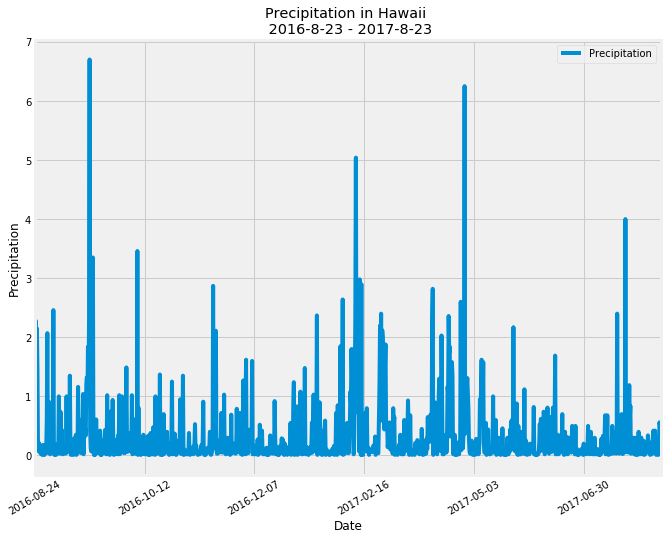

In [16]:
ry_df_cleaned = recent_year_df[recent_year_df.prcp !=0]
ry_df_cleaned = ry_df_cleaned.dropna(axis=0, how='any')
ry_df_cleaned.plot('date','prcp',figsize=(10,8))
plt.title("Precipitation in Hawaii \n 2016-8-23 - 2017-8-23")
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(["Precipitation"])
plt.xticks(rotation=30)

## Summary statistics for the precipitation data

In [17]:
prec = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.prcp, Measurement.station,Measurement.tobs).\
                 filter(Measurement.date >= year_ago_date).\
                 order_by(Measurement.date.asc()).statement,session.bind)
prec = prec.set_index(prec.date)
prec.rename(columns={
    "prcp":"Precipitation"
})
prec.describe()

,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


In [18]:
# Query to show how many stations are available in this dataset
session.query(Station.id).count()

9

## Most active stations

In [19]:
stat_all = pd.read_sql(session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).statement,session.bind)
stat_all = stat_all.rename(columns={
                            "id":"Station Id"
})
prec_all = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).statement,session.bind)
prec_all = prec_all.rename(columns={
                            "id":"Measurement Id"
                           })

merged = pd.merge(prec_all, stat_all, how='outer', on='station')

grouped = merged.groupby(by="Station Id").count()
s_count = grouped.iloc[:,[1]]
s_count = s_count.sort_values("date",ascending=False)
s_count = s_count.rename(columns={
    "date":"No. of Measurements"
})
stations_count = pd.merge(s_count,stat_all,how="outer",on='Station Id')
stations_count
stat_all

,Station Id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


## Statistics for the most active station

In [20]:
top_station = stations_count.name[0]
top_station_df = pd.read_sql(session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
                  filter(Station.name == top_station).\
                 order_by(Station.id.asc()).statement,session.bind)
top_station_df = merged[merged['name'] == top_station]
print(f"Most Active Station: {stations_count.name[0]}")
print("----------------------------------------")
print(f"Lowest recorded temperature: {top_station_df.tobs.min()}")
print(f"Highest recorded temperature: {top_station_df.tobs.max()}")
print(f"Average Temperature temperature: {top_station_df.tobs.mean()}")
top_station_df
print(merged["Measurement Id"].count())
merged

Most Active Station: WAIHEE 837.5, HI US
----------------------------------------
Lowest recorded temperature: 54.0
Highest recorded temperature: 85.0
Average Temperature temperature: 71.66378066378067
19550


,Measurement Id,date,prcp,station,tobs,Station Id,name,latitude,longitude,elevation
0,1,2010-01-01,0.08,USC00519397,65.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,2010-01-02,0.00,USC00519397,63.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,2010-01-03,0.00,USC00519397,74.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,2010-01-04,0.00,USC00519397,76.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,5,2010-01-06,NaN,USC00519397,73.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
5,6,2010-01-07,0.06,USC00519397,70.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
6,7,2010-01-08,0.00,USC00519397,64.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
7,8,2010-01-09,0.00,USC00519397,68.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
8,9,2010-01-10,0.00,USC00519397,73.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
9,10,2010-01-11,0.01,USC00519397,64.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


## Histogram of the last 12 months of temperature observation data for the most active station

Top station: WAIHEE 837.5, HI US


Text(0.5, 0, 'Temperature')

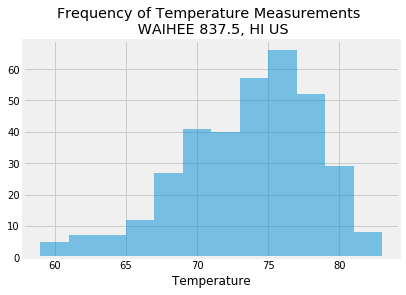

In [21]:
print(f"Top station: {top_station}")

top_df = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.prcp, Measurement.station,Measurement.tobs).\
                filter(Measurement.station==stations_count.station[0]).\
                filter(Measurement.date >= year_ago_date).\
                 order_by(Measurement.date.asc()).statement,session.bind)
top_temp_df = top_df["tobs"]


plt.hist(top_df["tobs"],bins=12, alpha=0.5)

plt.title(f"Frequency of Temperature Measurements \n {top_station}")
plt.xlabel('Temperature')

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' and return 
# the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Let's choose dates for a trip
trip_start_date = "2017-05-24"
trip_end_date = "2017-05-28"
trip_dates = calc_temps(trip_start_date,trip_end_date)
print(trip_dates)

[(69.0, 75.10344827586206, 82.0)]


In [24]:
min_temp = trip_dates[0][0]
avg_temp = trip_dates[0][1]
max_temp = trip_dates[0][2]
label = [f"{trip_start_date} through {trip_end_date}"]
x_pos = np.arange(len(label))

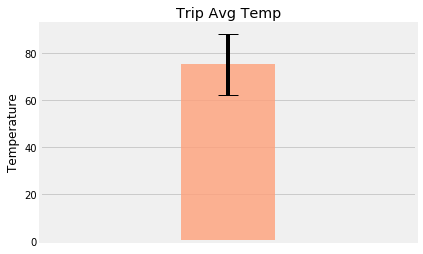

<Figure size 432x288 with 0 Axes>

In [25]:
fig, ax = plt.subplots()
ax.bar(x_pos, avg_temp, yerr=(max_temp-min_temp), align='center', alpha=0.8, color="lightsalmon", ecolor='black', capsize=10,width=0.02)
ax.set_ylabel('Temperature')
ax.set_xticks([])
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
plt.xlim(-.04,.04)
plt.show()

plt.savefig("test.png")

## Total amount of rainfall per weather station for  trip dates using the previous year's matching dates. Sorted in descending order by precipitation amount.


In [26]:
trip_prec = pd.read_sql(session.query(Measurement.id, Measurement.date, \
                                      Measurement.prcp, Measurement.station,Measurement.tobs).\
                 filter(Measurement.date >= trip_start_date).\
                 filter(Measurement.date <= trip_end_date).statement,session.bind)
trip_prec = trip_prec.groupby(by='station').sum()
trip_prec=trip_prec.sort_values("prcp",ascending=False)
trip_rainfall = pd.merge(trip_prec,stat_all,how="left",on="station")
trip_rainfall



,station,id,prcp,tobs,Station Id,name,latitude,longitude,elevation
0,USC00516128,97330,3.55,362.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00513117,26835,1.26,357.0,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00519523,60530,1.16,389.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00519281,74420,0.58,376.0,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00519397,10554,0.31,304.0,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00514830,37800,0.19,390.0,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
